##### Copyright 2018 The TensorFlow Authors.

In [88]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image Classification using tf.keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c03_exercise_flowers_with_data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c03_exercise_flowers_with_data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Bu Colab çalışmasında çiçek resimlerini sınıflandıracaksınız. tf.keras.Sequential modelini kullanarak bir görüntü sınıflandırıcı oluşturup tf.keras.preprocessing.image.ImageDataGenerator ile verileri yükleyeceksiniz.

* 210601027-Mert Tosun %34
* 210601009-Kutay Can Batur  %33
* 210601020-İbrahim Serhat Aktaş %33

# Importing Packages

Başlamak için gerekli paketleri içe aktaralım.

os paketi dosyaları ve dizin yapısını okumak için kullanılır, numpy ise python listesini numpy dizisine dönüştürmek ve gerekli matris işlemlerini yapmak için kullanılır ve matplotlib.pyplot ise grafik çizmek ve eğitim ve doğrulama verilerimizdeki resimleri görüntülemek için kullanılır.

In [89]:
import os
import numpy as np
import glob
import shutil

import tensorflow as tf

import matplotlib.pyplot as plt



### TODO: Import TensorFlow and Keras Layers


Aşağıdaki hücrede, TensorFlow'u tf olarak ve CNN'inizi oluşturmak için kullanacağınız Keras katmanlarını ve modellerini içe aktarın. Ayrıca, görüntü artırma işlemleri için Keras'tan ImageDataGenerator'ı da içe aktarın.


In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Data Loading


Görüntü sınıflandırıcımızı oluşturmaya başlamak için çiçekler veri setini indirmemiz gerekiyor. İlk olarak, veri setinin arşiv sürümünü indirmemiz gerekiyor ve indirme işleminden sonra "/tmp/" dizinine kaydediyoruz.
Veri setini indirdikten sonra, içeriğini çıkarmamız gerekiyor.

In [91]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

İndirdiğimiz veri seti 5 tür çiçeğin görsellerini içeriyor:

1. Gül
2. Papatya
3. Karahindiba
4. Ayçiçekleri
5. Laleler

Şimdi bu 5 sınıf için etiketler oluşturalım:

In [92]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

Ayrıca indirdiğimiz veri seti aşağıdaki dizin yapısına sahiptir.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

Gördüğünüz gibi eğitim ve doğrulama verilerini içeren klasör yok. Bu nedenle kendi eğitim ve doğrulama setimizi oluşturmamız gerekecek. Bunu yapacak bir kod yazalım.


Aşağıdaki kod, her biri 5 klasör (her çiçek türü için bir tane) içeren bir "train" ve bir "val" klasörü oluşturur. Daha sonra görüntüleri orijinal klasörlerden bu yeni klasörlere, görüntülerin %80'i eğitim setine ve %20'si doğrulama setine gidecek şekilde taşır. Sonunda dizinimiz aşağıdaki yapıya sahip olacak:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>dandelion</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>roses</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>sunflowers</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>tulips</b>: [1.jpg, 2.jpg, 3.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]
</pre>

Orijinal klasörleri silmediğimiz için hala `flower_photos` dizinimizde olacaklar ama boş olacaklar. Aşağıdaki kod ayrıca her çiçek türü için sahip olduğumuz toplam çiçek görseli sayısını da yazdırır.

In [93]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):] # yüzde sekseni egitim

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
      shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
      shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


Kolaylık olması açısından eğitim ve doğrulama kümelerinin yolunu ayarlayalım

In [94]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Data Augmentation

Aşırı uyum genellikle az sayıda eğitim örneğine sahip olduğumuzda ortaya çıkar. Bu sorunu çözmenin bir yolu, veri setimizi yeterli sayıda eğitim örneğine sahip olacak şekilde genişletmektir. Veri artırma, inandırıcı görünen görüntüler sağlayan bir dizi rastgele dönüşüm yoluyla örnekleri artırarak mevcut eğitim örneklerinden daha fazla eğitim verisi üretme yaklaşımını benimser. Amaç, eğitim sırasında modelinizin aynı resmi asla iki kez görmemesidir. Bu, modelin verilerin daha fazla yönüne maruz kalmasına ve daha iyi genelleştirilmesine yardımcı olur.

**tf.keras**'ta bunu daha önce kullandığımız **ImageDataGenerator** sınıfını kullanarak uygulayabiliriz. Argüman olarak veri setimize istediğimiz farklı dönüşümleri basitçe aktarabiliriz ve eğitim sürecimiz sırasında bunun veri setine uygulanmasına özen gösterecektir.
## Çeşitli Görüntü Dönüşümleriyle Deney Yapın

Bu bölümde bazı temel görüntü dönüşümlerini yaparak pratik yapacaksınız. Dönüşüm yapmaya başlamadan önce 'batch_size' ve resim boyutumuzu tanımlayalım. CNN'imize gönderilen girdilerin aynı boyuttaki resimler olduğunu unutmayın. Bu nedenle veri setimizdeki görselleri aynı boyuta yeniden boyutlandırmamız gerekiyor.

### TODO: Toplu İşi ve Görüntü Boyutunu Ayarlayın

Aşağıdaki hücrede 100 görüntüden oluşan bir 'batch_size' oluşturun ve eğitim verilerimizin 150 piksel genişliğinde ve 150 piksel yüksekliğinde görüntülerden oluşmasını sağlayacak şekilde 'IMG_SHAPE' değerini ayarlayın.

## Çeşitli Görüntü Dönüşümleriyle Deney Yapın

Bu bölümde bazı temel görüntü dönüşümlerini yaparak pratik yapacaksınız. Dönüşüm yapmaya başlamadan önce 'batch_size' ve resim boyutumuzu tanımlayalım. CNN'imize gönderilen girdilerin aynı boyuttaki resimler olduğunu unutmayın. Bu nedenle veri setimizdeki görselleri aynı boyuta yeniden boyutlandırmamız gerekiyor.

### TODO: Toplu İşi ve Görüntü Boyutunu Ayarlayın

Aşağıdaki hücrede 100 görüntüden oluşan bir 'batch_size' oluşturun ve eğitim verilerimizin 150 piksel genişliğinde ve 150 piksel yüksekliğinde görüntülerden oluşmasını sağlayacak şekilde 'IMG_SHAPE' değerini ayarlayın.

In [95]:
batch_size = 32
IMG_SHAPE = (150,150,3)

### TODO: Apply Random Horizontal Flip

Aşağıdaki hücrede, görüntüleri 255 oranında yeniden ölçeklendiren ve ardından rastgele bir yatay çevirme uygulayan bir dönüşüm oluşturmak için ImageDataGenerator'ı kullanın. Daha sonra yukarıdaki dönüşümü eğitim setimizdeki görsellere uygulamak için `.flow_from_directory` yöntemini kullanın. Toplu iş boyutunu, eğitim görüntüleri dizininin yolunu, görüntülerin hedef boyutunu ve görüntüleri karıştırmayı belirttiğinizden emin olun.

In [96]:

image_gen =ImageDataGenerator(
    rescale=1./255,   # normalizsayon için 
    horizontal_flip=True
)

train_data_gen = image_gen.flow_from_directory(
    #'flow_from_directory',  # Veri setinin bulunduğu dizin
    #1target_size=(IMG_SHAPE[0], IMG_SHAPE[1]),  # Görüntülerin hedef boyutu
    directory = train_dir,
    batch_size=batch_size,  # Batch boyutu
    class_mode='binary',  # Sınıf modu (binary classification)
    shuffle=True  # Verileri karıştır
)

Found 2935 images belonging to 5 classes.


Eğitim örneklerimizden 1 örnek görüntü alalım ve bunu 5 kez tekrarlayalım, böylece büyütmeyi çalışırken görmek için büyütme aynı görüntüye rastgele 5 kez uygulanabilir.

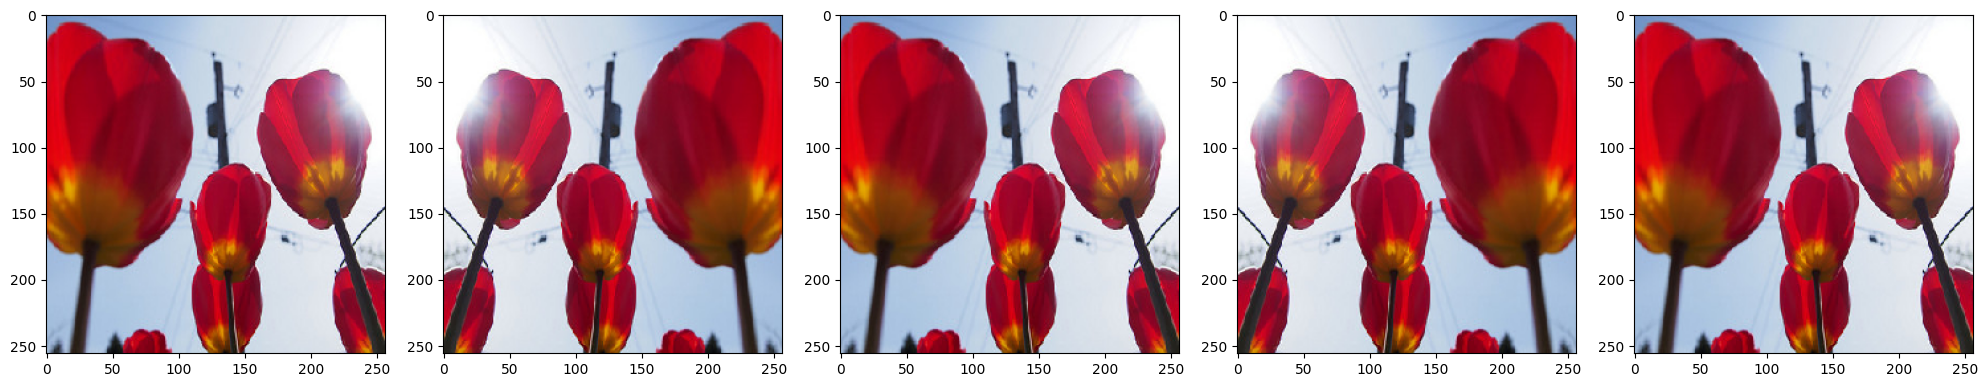

In [97]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][1] for i in range(5)]
plotImages(augmented_images)

### TODO: Apply Random Rotation

Aşağıdaki hücrede, görüntüleri 255 oranında yeniden ölçeklendiren ve ardından rastgele 45 derecelik bir dönüş uygulayan bir dönüşüm oluşturmak için ImageDataGenerator'ı kullanın. Daha sonra yukarıdaki dönüşümü eğitim setimizdeki görsellere uygulamak için `.flow_from_directory` yöntemini kullanın. Toplu iş boyutunu, eğitim görüntüleri dizininin yolunu, görüntülerin hedef boyutunu ve görüntüleri karıştırmayı belirttiğinizden emin olun.
Bu kod parçacığı, veri artırma işlemlerine bir özellik daha ekleyerek veri setini daha çeşitli hale getirir. Görüntüler rastgele olarak en fazla 45 derece döndürülerek farklı açılardan öğrenilmesi sağlanır. Bu da modelin daha iyi genelleme yapmasına ve daha çeşitli veri setlerine uyum sağlamasına yardımcı olabilir.

In [98]:
image_gen = image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45
)

train_data_gen = image_gen.flow_from_directory(
    directory = train_dir,
    target_size=(IMG_SHAPE[0], IMG_SHAPE[1]),  # Görüntülerin hedef boyutu
    batch_size=batch_size,  # Batch boyutu
    class_mode='binary',  # Sınıf modu (binary classification)
    shuffle=True  # Verileri karıştır
)

Found 2935 images belonging to 5 classes.


Eğitim örneklerimizden 1 örnek görüntü alalım ve bunu 5 kez tekrarlayalım, böylece büyütmeyi çalışırken görmek için büyütme aynı görüntüye rastgele 5 kez uygulanabilir.

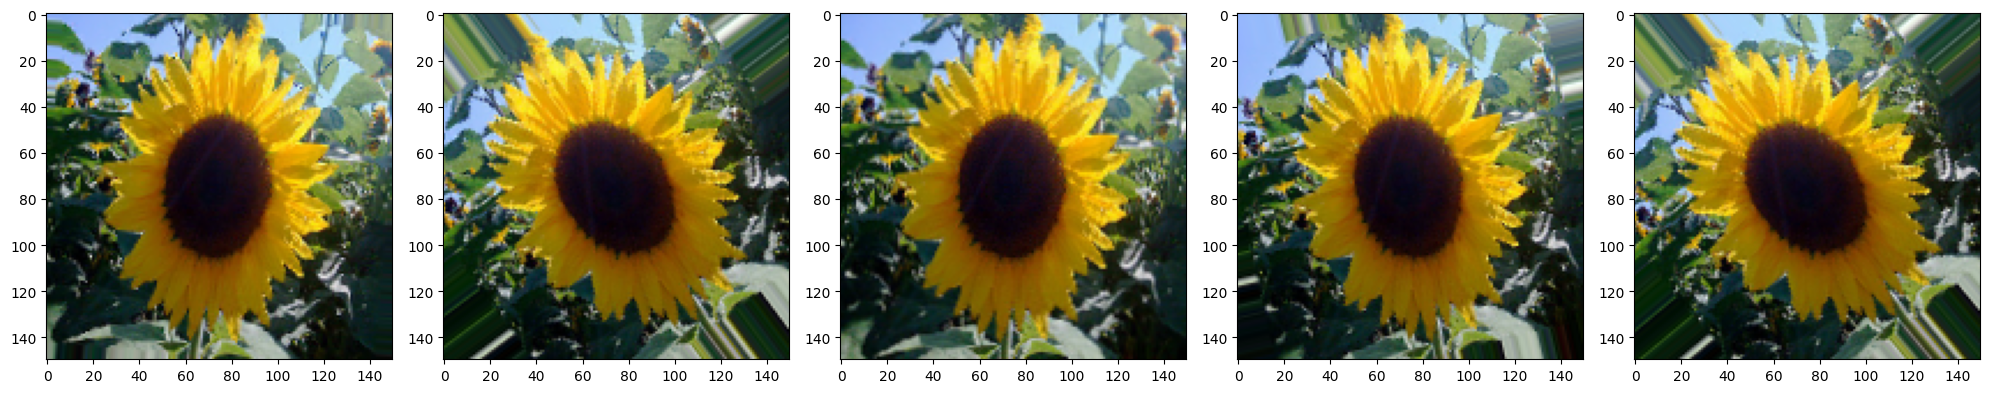

In [99]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### TODO: Apply Random Zoom

Aşağıdaki hücrede, görüntüleri 255 oranında yeniden ölçeklendiren ve ardından %50'ye kadar rastgele yakınlaştırma uygulayan bir dönüşüm oluşturmak için ImageDataGenerator'ı kullanın. Daha sonra yukarıdaki dönüşümü eğitim setimizdeki görsellere uygulamak için `.flow_from_directory` yöntemini kullanın. Toplu iş boyutunu, eğitim görüntüleri dizininin yolunu, görüntülerin hedef boyutunu ve görüntüleri karıştırmayı belirttiğinizden emin olun.

In [100]:
image_gen = image_gen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.5
)

train_data_gen = image_gen.flow_from_directory(
    directory = train_dir,
    target_size=(IMG_SHAPE[0], IMG_SHAPE[1]),  # Görüntülerin hedef boyutu
    batch_size=batch_size,  # Batch boyutu
    class_mode='binary',  # Sınıf modu (binary classification)
    shuffle=True  # Verileri karıştır
)

Found 2935 images belonging to 5 classes.


Eğitim örneklerimizden 1 örnek görüntü alalım ve bunu 5 kez tekrarlayalım, böylece büyütmeyi çalışırken görmek için büyütme aynı görüntüye rastgele 5 kez uygulanabilir.

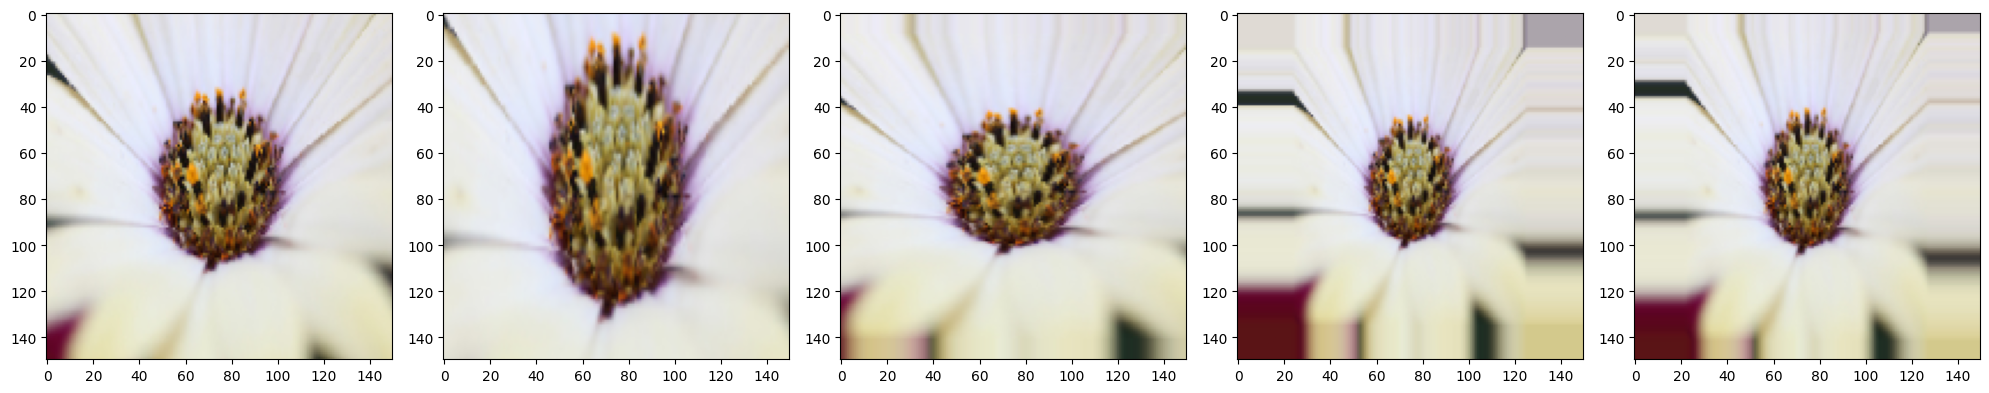

In [101]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Aşağıdaki hücrede, görüntüleri 255 oranında yeniden ölçeklendiren ve geçerli olan bir dönüşüm oluşturmak için ImageDataGenerator'ı kullanın:

- rastgele 45 derece dönüş
- %50'ye kadar rastgele yakınlaştırma
- rastgele yatay çevirme
- 0,15 genişlik kayması
- 0,15'lik yükseklik kayması

Daha sonra yukarıdaki dönüşümü eğitim setimizdeki görsellere uygulamak için `.flow_from_directory` yöntemini kullanın. Toplu iş boyutunu, eğitim görüntülerinin dizininin yolunu, görüntülerin hedef boyutunu, görüntüleri karıştırmayı ve sınıf modunu 'seyrek' olarak ayarlamayı belirttiğinizden emin olun.

In [102]:
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.5,
    horizontal_flip=True
)


train_data_gen = image_gen_train.flow_from_directory(
    directory = train_dir,
    target_size=(IMG_SHAPE[0], IMG_SHAPE[1]),  # Görüntülerin hedef boyutu
    batch_size=batch_size,  # Batch boyutu
    class_mode='sparse',  # Sınıf modu (sparse classification)
    shuffle=True  # Verileri karıştır
)

Found 2935 images belonging to 5 classes.


Bu büyütmeleri veri setimize rastgele aktardığımızda tek bir görüntünün 5 farklı kez nasıl görüneceğini görselleştirelim.

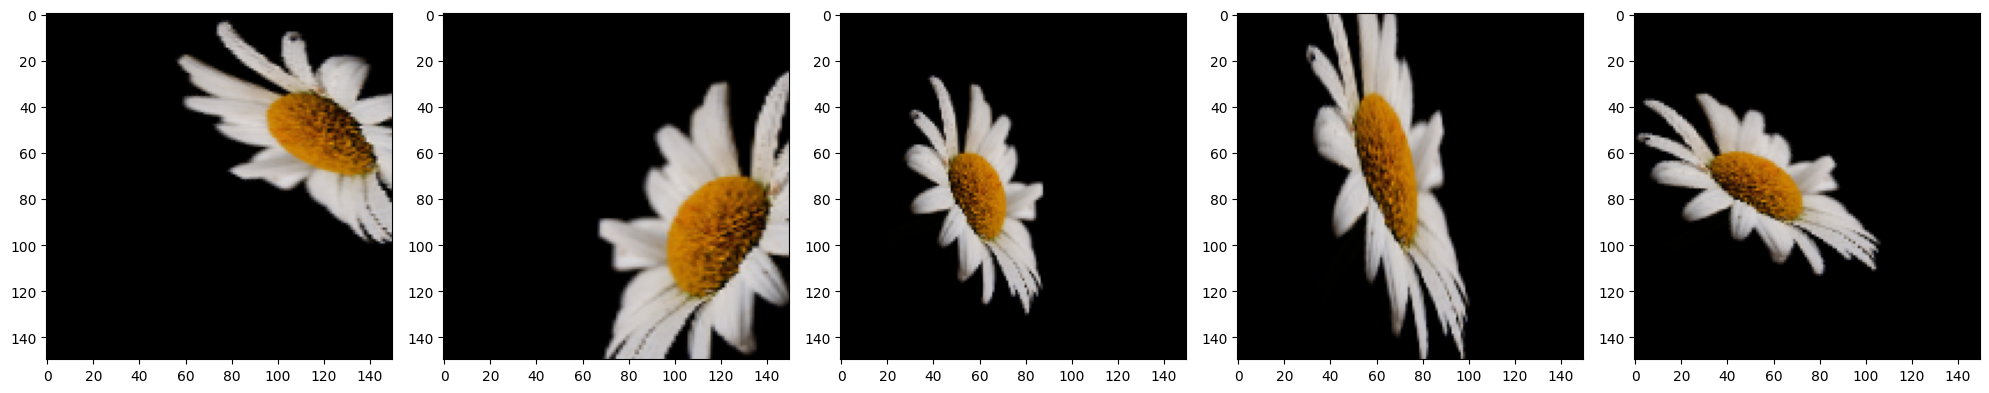

In [103]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### TODO: Create a Data Generator for the Validation Set

Genellikle veri artırmayı yalnızca eğitim örneklerimize uygularız. Dolayısıyla, aşağıdaki hücrede, görüntüleri yalnızca 255 oranında yeniden ölçeklendiren bir dönüşüm oluşturmak için ImageDataGenerator'ı kullanın. Ardından, yukarıdaki dönüşümü doğrulama setimizdeki görüntülere uygulamak için `.flow_from_directory` yöntemini kullanın. Toplu iş boyutunu, doğrulama görüntülerinin dizininin yolunu, görüntülerin hedef boyutunu belirttiğinizden ve sınıf modunu 'seyrek' olarak ayarladığınızdan emin olun. Doğrulama kümesindeki görüntüleri karıştırmanın gerekli olmadığını unutmayın.

In [104]:
# @title
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    directory = train_dir,
    target_size=(IMG_SHAPE[0], IMG_SHAPE[1]),  # Görüntülerin hedef boyutu
    batch_size=batch_size,  # Batch boyutu
    class_mode='sparse',  # Sınıf modu (sparse classification)
    shuffle=False  # Verileri karıştırma (karıştırmak gerekmez)
)

Found 2935 images belonging to 5 classes.


# TODO: Create the CNN

Aşağıdaki hücrede 3 evrişim bloğundan oluşan bir evrişimli sinir ağı oluşturun. Her evrişimli blok, bir 'Conv2D' katmanını ve ardından bir maksimum havuz katmanını içerir. İlk evrişim bloğunda 16 filtre, ikincisinde 32 filtre ve üçüncüsünde ise 64 filtre bulunmalıdır. Tüm evrişimli filtreler 3 x 3 olmalıdır. Tüm maksimum havuz katmanlarının "pool_size" değeri "(2, 2)" olmalıdır.

3 evrişimli bloktan sonra düzleştirilmiş bir katmana ve ardından 512 birimlik tam bağlantılı bir katmana sahip olmalısınız. CNN, **softmax** aktivasyon fonksiyonu tarafından gerçekleştirilen 5 sınıfa dayalı olarak sınıf olasılıklarının çıktısını vermelidir. Diğer tüm katmanlar **relu** etkinleştirme işlevini kullanmalıdır. Uygun olduğunda %20 olasılıkla Dropout katmanlarını da eklemelisiniz.

In [105]:


# Model oluşturma
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
])

# Model özetini görüntüleme
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 74, 74, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 36, 36, 32)       

# TODO: Compile the Model

Aşağıdaki hücrede, seyrek çapraz entropi fonksiyonunu bir kayıp fonksiyonu olarak kullanan ADAM optimizerini kullanarak modelinizi derleyin. Ağımızı eğitirken her dönemdeki eğitim ve doğrulama doğruluğuna da bakmak isteriz, bu nedenle metrik argümanını da geçtiğinizden emin olun.

In [106]:
# Modeli derleme
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# TODO: Train the Model

Aşağıdaki hücrede, normal **fit** işlevi yerine **fit_generator** işlevini kullanarak modelinizi eğitin. Modelimiz için toplu eğitim ve doğrulama verileri oluşturmak amacıyla **ImageDataGenerator** sınıfını kullandığımız için `fit_generator` işlevini kullanmak zorundayız. Modeli 80 dönem boyunca eğitin ve 'fit_generator' işlevinde doğru parametreleri kullandığınızdan emin olun.

In [107]:
epochs = 50

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=len(train_data_gen),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=len(val_data_gen)
)

C:\Users\Mert\AppData\Local\Temp\ipykernel_3124\2989362518.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
92/92 [==============================] - 37s 390ms/step - loss: 1.5672 - accuracy: 0.3135 - val_loss: 1.2750 - val_accuracy: 0.4562
Epoch 2/50
92/92 [==============================] - 34s 373ms/step - loss: 1.2226 - accuracy: 0.4920 - val_loss: 1.1504 - val_accuracy: 0.5383
Epoch 3/50
92/92 [==============================] - 33s 359ms/step - loss: 1.1261 - accuracy: 0.5223 - val_loss: 1.0422 - val_accuracy: 0.5908
Epoch 4/50
92/92 [==============================] - 32s 347ms/step - loss: 1.0566 - accuracy: 0.5629 - val_loss: 0.9488 - val_accuracy: 0.6167
Epoch 5/50
92/92 [==============================] - 32s 343ms/step - loss: 1.0204 - accuracy: 0.5840 - val_loss: 0.8998 - val_accuracy: 0.6446
Epoch 6/50
92/92 [==============================] - 33s 355ms/step - loss: 0.9640 - accuracy: 0.6174 - val_loss: 0.8585 - val_accuracy: 0.6586
Epoch 7/50
92/92 [==============================] - 32s 345ms/step - loss: 0.9353 - accuracy: 0.6313 - val_loss: 0.8188 - val_accuracy: 0.6801

# TODO: Plot Training and Validation Graphs.

Aşağıdaki hücrede eğitim ve doğrulama doğruluk/kayıp grafiklerini çizin.

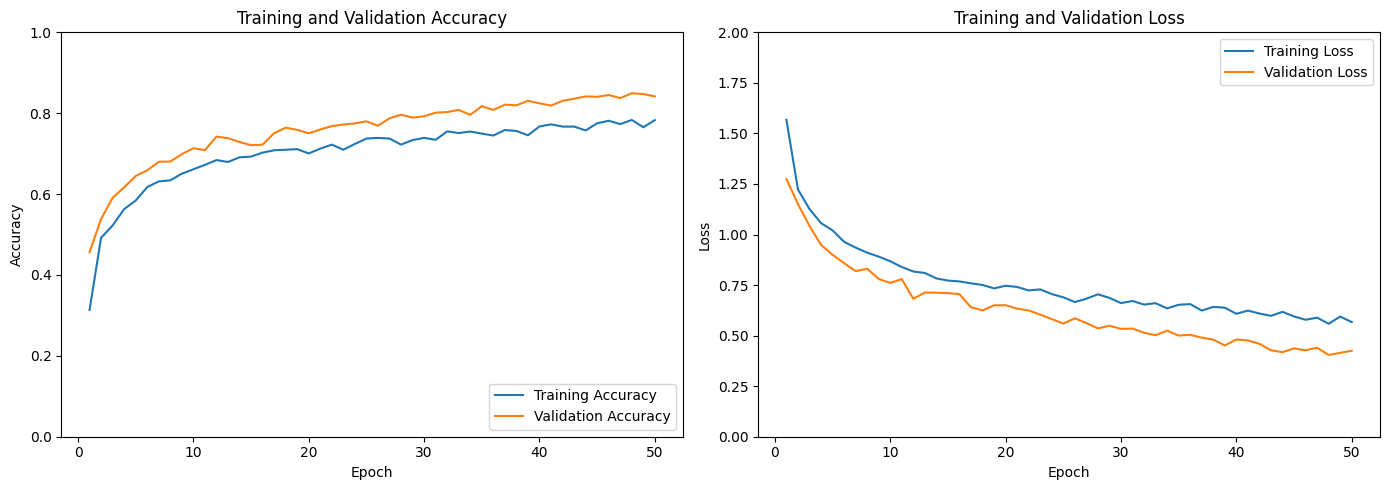

In [108]:

# Eğitim ve doğrulama metriklerini alın
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Epoch aralığını belirleme
epochs_range = range(1, epochs + 1)

# Eğitim ve doğrulama doğruluk grafiği
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])

# Eğitim ve doğrulama kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])

# Grafiği gösterme
plt.tight_layout()
plt.show()


# TODO: Experiment with Different Parameters

Şu ana kadar 3 evrişimli katmana sahip bir CNN oluşturdunuz ve ardından 512 birimlik tam bağlantılı bir katman izlediniz. Aşağıdaki hücrelerde farklı mimariye sahip yeni bir CNN oluşturun. İstediğiniz kadar parametreyi değiştirerek deneme yapmaktan çekinmeyin. Örneğin, daha fazla evrişimli katman veya daha fazla tam bağlı katman ekleyebilirsiniz. Ayrıca evrişimli katmanlarınızda farklı filtre boyutları, tamamen bağlı katmanlarınızdaki farklı sayıda birim, farklı bırakma oranları vb. ile denemeler yapabilirsiniz. Şu ana kadar gördüğümüz daha fazla görüntü dönüşümüyle görüntü büyütme gerçekleştirerek de denemeler yapabilirsiniz. Mevcut tüm görüntü dönüşümlerinin tam listesini görmek için [ImageDataGenerator Belgelerine](https://keras.io/preprocessing/image/) göz atın. Örneğin, kayma dönüşümleri ekleyebilir veya görüntülerin parlaklığını değiştirebilirsiniz, vb... Yapabildiğiniz kadar deneme yapın ve çeşitli modellerinizin doğruluğunu karşılaştırın. Hangi parametreler size en iyi sonucu verir?